In [1]:
import torch
import sys
sys.path.append("../")
from ad_utils import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train, X_test, y_train, y_test = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A30
(872, 4500, 14) (872,)


# Vanilla GAN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Vanilla GAN Generator
class VanillaGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_features=14, seq_len=4500):
        super(VanillaGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.n_features = n_features
        self.seq_len = seq_len
        
        # Calculate reasonable initial size
        self.init_size = max(seq_len // 64, 32)
        
        # Initial projection
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size),
            nn.BatchNorm1d(128 * self.init_size),
            nn.ReLU(inplace=True)
        )
        
        # Upsampling blocks
        self.conv_blocks = nn.Sequential(
            # 128 -> 64 channels
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            # 64 -> 32 channels
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            # 32 -> 16 channels
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            
            # 16 -> n_features channels
            nn.ConvTranspose1d(16, n_features, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in [-1, 1]
        )
        
    def forward(self, z):
        # Project latent to initial conv size
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size)
        
        # Progressive upsampling
        out = self.conv_blocks(out)
        
        # Ensure exact sequence length
        if out.shape[2] != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        # Return as (batch_size, seq_len, n_features)
        return out.transpose(1, 2)

# Vanilla GAN Discriminator
class VanillaGANDiscriminator(nn.Module):
    def __init__(self, n_features=14, seq_len=4500):
        super(VanillaGANDiscriminator, self).__init__()
        
        # Downsampling blocks
        self.conv_blocks = nn.Sequential(
            # n_features -> 16 channels
            nn.Conv1d(n_features, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 16 -> 32 channels
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 32 -> 64 channels
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 64 -> 128 channels
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate output size after convolutions
        self.conv_output_size = self._get_conv_output_size(seq_len)
        
        # Binary classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 * self.conv_output_size, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )
        
    def _get_conv_output_size(self, seq_len):
        size = seq_len
        for _ in range(4):  # 4 conv layers
            size = (size - 4 + 2) // 2 + 1
        return size
    
    def forward(self, x):
        # Input: (batch_size, seq_len, n_features)
        x = x.transpose(1, 2)  # Convert to (batch_size, n_features, seq_len)
        
        # Apply conv blocks
        features = self.conv_blocks(x)
        
        # Flatten and classify
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        
        return output

# Vanilla GAN training function
def train_vanilla_gan(normal_data, device, n_epochs=50, batch_size=32, lr_g=2e-4, lr_d=2e-4):
    """
    Train Vanilla GAN with binary cross-entropy loss
    """
    print(f"Starting Vanilla GAN Training")
    print(f"Data shape: {normal_data.shape}")
    print(f"Raw data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")
    
    # Data preprocessing - scale to [-1, 1] for tanh output
    data_mean = np.mean(normal_data, axis=(0, 1), keepdims=True)
    data_std = np.std(normal_data, axis=(0, 1), keepdims=True) + 1e-8
    
    # Normalize to [-1, 1]
    normalized_data = (normal_data - data_mean) / data_std
    normalized_data = np.tanh(normalized_data)  # Ensure [-1, 1] range
    
    print(f"Normalized data range: [{normalized_data.min():.4f}, {normalized_data.max():.4f}]")
    
    # Model parameters
    latent_dim = 100
    n_features = normalized_data.shape[-1]
    seq_len = normalized_data.shape[1]
    
    # Initialize models
    generator = VanillaGANGenerator(latent_dim, n_features, seq_len).to(device)
    discriminator = VanillaGANDiscriminator(n_features, seq_len).to(device)
    
    # Weight initialization
    def init_weights(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)
    
    generator.apply(init_weights)
    discriminator.apply(init_weights)
    
    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Create dataloader
    dataset = TensorDataset(torch.tensor(normalized_data, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print(f"Training Parameters:")
    print(f"  Epochs: {n_epochs}, Batch Size: {batch_size}")
    print(f"  Generator LR: {lr_g}, Discriminator LR: {lr_d}")
    
    # Training history
    d_losses = []
    g_losses = []
    d_accuracies = []
    
    print("\nStarting Training...")
    print("=" * 60)
    
    for epoch in range(n_epochs):
        epoch_d_losses = []
        epoch_g_losses = []
        epoch_d_accuracies = []
        
        for i, (real_samples,) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            batch_size_actual = real_samples.size(0)
            
            # Real and fake labels
            real_labels = torch.ones(batch_size_actual, 1, device=device)
            fake_labels = torch.zeros(batch_size_actual, 1, device=device)
            
            # ========================
            # Train Discriminator
            # ========================
            optimizer_D.zero_grad()
            
            # Real samples
            real_output = discriminator(real_samples)
            d_loss_real = criterion(real_output, real_labels)
            
            # Generate fake samples
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_samples = generator(z).detach()
            fake_output = discriminator(fake_samples)
            d_loss_fake = criterion(fake_output, fake_labels)
            
            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()
            
            # Calculate discriminator accuracy
            real_pred = (real_output > 0.5).float()
            fake_pred = (fake_output > 0.5).float()
            d_accuracy = ((real_pred == real_labels).sum() + (fake_pred == fake_labels).sum()).float() / (2 * batch_size_actual)
            
            epoch_d_losses.append(d_loss.item())
            epoch_d_accuracies.append(d_accuracy.item())
            
            # ========================
            # Train Generator
            # ========================
            optimizer_G.zero_grad()
            
            # Generate fake samples
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_samples = generator(z)
            fake_output = discriminator(fake_samples)
            
            # Generator loss (wants discriminator to classify fakes as real)
            g_loss = criterion(fake_output, real_labels)
            
            g_loss.backward()
            optimizer_G.step()
            
            epoch_g_losses.append(g_loss.item())
        
        # Calculate epoch averages
        avg_d_loss = np.mean(epoch_d_losses)
        avg_g_loss = np.mean(epoch_g_losses)
        avg_d_accuracy = np.mean(epoch_d_accuracies)
        
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        d_accuracies.append(avg_d_accuracy)
        
        # Print progress
        if epoch % 5 == 0 or epoch == n_epochs - 1:
            print(f"Epoch [{epoch+1:3d}/{n_epochs}] | "
                  f"D Loss: {avg_d_loss:8.4f} | "
                  f"G Loss: {avg_g_loss:8.4f} | "
                  f"D Acc: {avg_d_accuracy:6.3f}")
            
            # Check for mode collapse or training issues
            if avg_d_accuracy < 0.1 or avg_d_accuracy > 0.9:
                print("         ⚠️  Potential training instability detected")
            elif 0.4 <= avg_d_accuracy <= 0.6:
                print("         ✅ Training appears balanced")
    
    print("=" * 60)
    print("Training completed!")
    
    # Store normalization parameters for generation
    data_stats = (data_mean, data_std)
    
    return generator, discriminator, d_losses, g_losses, d_accuracies, data_stats

# Sample generation for Vanilla GAN
def generate_vanilla_samples(generator, num_samples, latent_dim, device, data_stats, batch_size=32):
    """
    Generate samples and denormalize them
    """
    generator.eval()
    data_mean, data_std = data_stats
    
    generated_batches = []
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            # Generate noise
            z = torch.randn(current_batch_size, latent_dim, device=device)
            
            # Generate samples
            batch_generated = generator(z)
            
            # Denormalize from [-1, 1] back to original scale
            batch_generated = batch_generated.cpu().numpy()
            batch_generated = np.arctanh(np.clip(batch_generated, -0.99, 0.99))  # Inverse tanh
            batch_generated = batch_generated * data_std + data_mean
            
            generated_batches.append(batch_generated)
    
    return np.concatenate(generated_batches, axis=0)

# Visualization for Vanilla GAN
def plot_vanilla_training_curves(d_losses, g_losses, d_accuracies):
    """
    Plot training curves for Vanilla GAN
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Discriminator loss
    axes[0].plot(d_losses, label='Discriminator Loss', color='blue', alpha=0.7)
    axes[0].set_title('Discriminator Loss Over Time')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Generator loss
    axes[1].plot(g_losses, label='Generator Loss', color='red', alpha=0.7)
    axes[1].set_title('Generator Loss Over Time')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Discriminator accuracy
    axes[2].plot(d_accuracies, label='Discriminator Accuracy', color='green', alpha=0.7)
    axes[2].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Random Guess')
    axes[2].set_title('Discriminator Accuracy Over Time')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].set_ylim(0, 1)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Train, and generate

Training Vanilla GAN...
Starting Vanilla GAN Training
Data shape: (552, 4500, 14)
Raw data range: [-5.7248, 7.6610]
Normalized data range: [-1.0000, 1.0000]
Training Parameters:
  Epochs: 200, Batch Size: 32
  Generator LR: 0.001, Discriminator LR: 5e-06

Starting Training...
Epoch [  1/200] | D Loss:   1.7027 | G Loss:   0.5135 | D Acc:  0.352
Epoch [  6/200] | D Loss:   1.7711 | G Loss:   0.4211 | D Acc:  0.411
         ✅ Training appears balanced
Epoch [ 11/200] | D Loss:   1.5016 | G Loss:   0.4840 | D Acc:  0.528
         ✅ Training appears balanced
Epoch [ 16/200] | D Loss:   1.3589 | G Loss:   0.5677 | D Acc:  0.608
Epoch [ 21/200] | D Loss:   1.5770 | G Loss:   0.5481 | D Acc:  0.447
         ✅ Training appears balanced
Epoch [ 26/200] | D Loss:   1.5648 | G Loss:   0.5781 | D Acc:  0.388
Epoch [ 31/200] | D Loss:   1.6531 | G Loss:   0.5528 | D Acc:  0.271
Epoch [ 36/200] | D Loss:   1.6887 | G Loss:   0.5477 | D Acc:  0.212
Epoch [ 41/200] | D Loss:   1.6529 | G Loss:   0.581

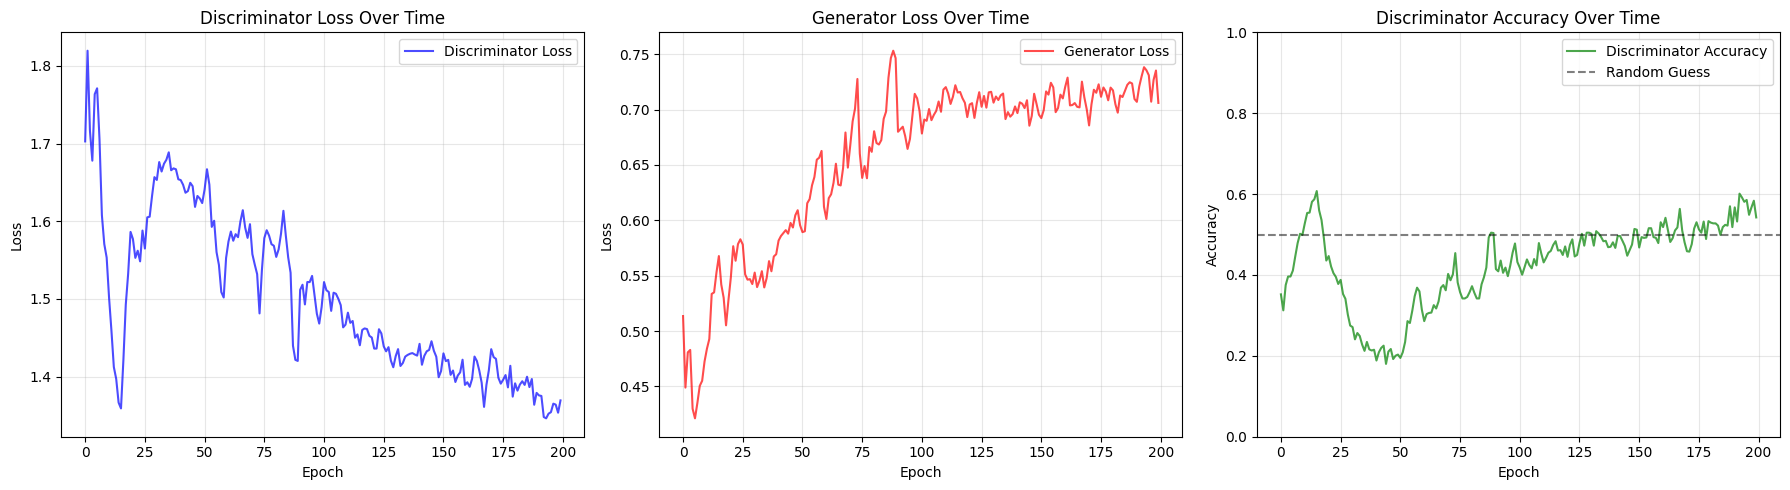

Generating synthetic samples...
Generated data shape: (552, 4500, 14)
Generated data range: [-2.7971, 2.7890]
Original data range: [-5.7248, 7.6610]


In [3]:
# Train the ultra-stable WGAN
print("Training Vanilla GAN...")
generator, discriminator, d_history, g_history, d_acc_history, data_stats = train_vanilla_gan(
    X_train,
    device,
    n_epochs=200,
    batch_size=32,
    lr_g=0.001,
    lr_d=0.000005
)

# Plot training curves
plot_vanilla_training_curves(d_history, g_history, d_acc_history)

# Generate samples
print("Generating synthetic samples...")
num_samples = len(X_train)
generated_data = generate_vanilla_samples(
    generator,
    num_samples,
    latent_dim=100,
    device=device,
    data_stats=data_stats,
    batch_size=32
)

print(f"Generated data shape: {generated_data.shape}")
print(f"Generated data range: [{generated_data.min():.4f}, {generated_data.max():.4f}]")
print(f"Original data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")



# FID Score

In [4]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train[:100]  # Use 100 samples for testing
test_generated = generated_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9816]
Fake images range: [0.0000, 1.0000]
After clamping - Real images range: [0.0000, 0.9816]
After clamping - Fake images range: [0.0000, 1.0000]
FID Score: 39.0633

🎉 SUCCESS! FID Score: 39.0633
Quality Assessment: Fair



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 552
Faulty samples: 182
Generated samples: 552
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 441
Fold 1 - Test: 147 (111 normal, 36 faulty)
Fold 1 - Augmented normal data: 993 samples
Processing data through feature extraction...
Processing 993 samples with multi-channel approach...
Processed 0/993 samples
Processed 100/993 samples
Processed 200/993 samples
Processed 300/993 samples
Processed 400/993 samples
Processed 500/993 samples
Processed 600/993 samples
Processed 700/993 samples
Processed 800/993 samples
Processed 900/993 samples
Processing 147 samples with multi-channel approach...
Processed 0/147 samples
Processed 100/147 samples
Training autoencoder...
Epoch 1/200, Loss: 1.060557
Epoch 2/200, Loss: 0.608414
Epoch 3/200, Loss: 0.512876
Epoch 4/200, Loss: 0.509528
Epoch 5/200, Loss: 0.508379
Epoch 6/200, Loss: 0.508370
Epoch 7/200, Loss: 0

/home/maddie/SmartIoT-2025/GANs models/Vanilla GANs/../ad_utils.py:1009: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(methods, rotation=45, ha='right')


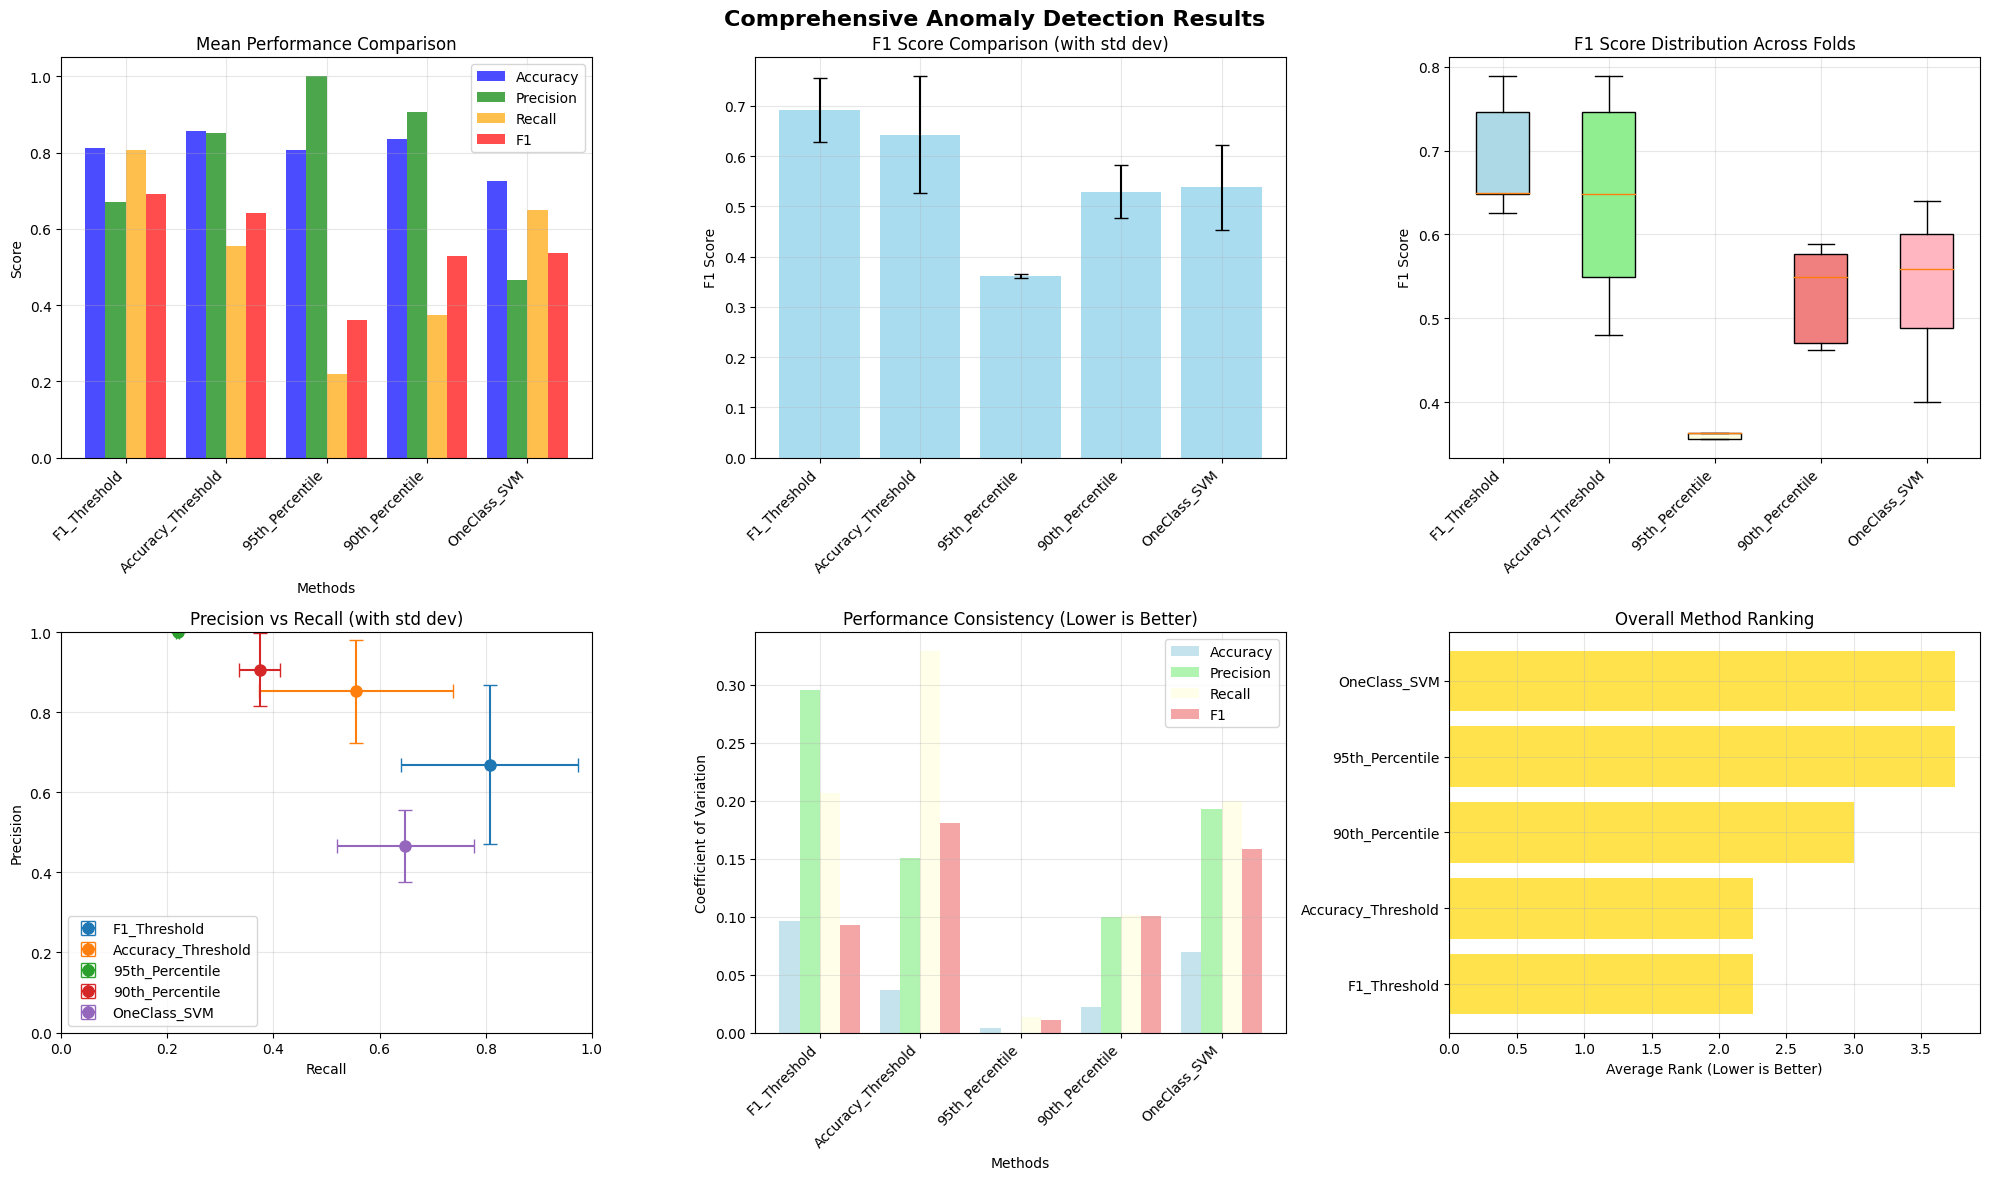


ANOMALY DETECTION RECOMMENDATIONS

🏆 BEST METHODS:
   • Best F1 Score: F1_Threshold (0.6914)
   • Best Accuracy: Accuracy_Threshold (0.8570)

📊 METHOD CHARACTERISTICS:
   • F1_Threshold          : High Recall (catches more anomalies), Variable
   • Accuracy_Threshold    : High Precision (fewer false alarms), Variable
   • 95th_Percentile       : High Precision (fewer false alarms), Stable
   • 90th_Percentile       : High Precision (fewer false alarms), Stable
   • OneClass_SVM          : High Recall (catches more anomalies), Variable

🎯 USE CASE RECOMMENDATIONS:
   • For Critical Systems (minimize false negatives): Use method with highest recall
   • For Cost-Sensitive Systems (minimize false alarms): Use method with highest precision
   • For Balanced Performance: Use F1_Threshold
   • For Simplicity: Use 95th_Percentile - no hyperparameter tuning needed
   • For Robustness: Use OneClass_SVM - adapts to data distribution



({'F1_Threshold': {'accuracy': {'mean': 0.8120957972229987,
    'std': 0.07807835639983149,
    'values': [0.7142857142857143,
     0.8299319727891157,
     0.8979591836734694,
     0.7278911564625851,
     0.8904109589041096]},
   'precision': {'mean': 0.6696377306903623,
    'std': 0.19760907953154594,
    'values': [0.4605263157894737,
     0.6571428571428571,
     1.0,
     0.4805194805194805,
     0.75]},
   'recall': {'mean': 0.8078078078078079,
    'std': 0.16650223200766348,
    'values': [0.9722222222222222,
     0.6388888888888888,
     0.5945945945945946,
     1.0,
     0.8333333333333334]},
   'f1': {'mean': 0.6914493054072277,
    'std': 0.06428594534549877,
    'values': [0.625,
     0.647887323943662,
     0.7457627118644068,
     0.6491228070175439,
     0.7894736842105262]}},
  'Accuracy_Threshold': {'accuracy': {'mean': 0.8569937564066723,
    'std': 0.03116117324626883,
    'values': [0.8435374149659864,
     0.8299319727891157,
     0.8979591836734694,
     0.823129

In [5]:
run_comprehensive_cross_validation_experiment(X_train, faulty_data, device, generated_data, epochs=200, batch_size=32)